In [1]:
from collections import defaultdict
import regex as re
import toolz
from dataclasses import dataclass, asdict
from functools import reduce
import random
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
import typing
import numpy as np
from Bio.SeqIO.UniprotIO import UniprotIterator
import json
from Claire.code import *

In [2]:
load = True

if load:
    with open(r'Claire\db_prots.json') as f:
        db_prots = json.load(f)
    
else:
    db_paths = [r"C:\Users\peter\OneDrive\Desktop\Claire's Virion Data\HIV_WTJB474_P6-chain_InterRT-chain_P6-pol.xml",
                r"C:\Users\peter\OneDrive\Desktop\Claire's Virion Data\uniprotkb_human_AND_model_organism_9606_2024_12_12.xml"]
    db_prots = {}
    for dbp in db_paths:
        for prot in UniprotIterator(dbp):
            if prot.id not in db_prots.keys():
                db_prots[prot.id] = {'seq': str(prot.seq),
                                     'from_file': []}
            else:
                print(f"already seen {prot.id} in {db_prots[prot.id]['from_file']}.")
                
                if db_prots[prot.id]['seq'] in prot.seq:
                    print(f"{prot.id}: Updating {db_prots[prot.id]['seq']} to {prot.seq}")
                    db_prots[prot.id]['seq'] = str(prot.seq)
                else: 
                    print("the new observation has a new sequence not containing the current sequence.")
            
            if dbp not in db_prots[prot.id]['from_file']:
                db_prots[prot.id]['from_file'].append(dbp)
    
    with open(r'Claire\db_prots.json', 'w') as f:
        json.dump(db_prots, f)


print(len(db_prots))

20446


In [3]:
quantified_peptides_path = r"C:\Users\peter\OneDrive\Desktop\Claire's Virion Data\2025-05-14-10-54-29\Task2-SearchTask\AllQuantifiedPeptides.tsv"
experimental_design_path = r"C:\Users\peter\OneDrive\Desktop\Claire's Virion Data\ExperimentalDesign.tsv"


with open(experimental_design_path, 'r') as f:
    rows = f.readlines()
    exp_headers = rows[0].strip('\n').lower().split('\t')
    design_info = defaultdict(dict)

    for r in rows[1:]:
        r = r.strip('\n').split('\t')
        info = dict(zip(exp_headers, r))
        design_info[r[0]] = info


with open(quantified_peptides_path, 'r') as f:
    rows = f.readlines()
    print(len(rows))
    data_headers = rows[0].strip('\n').replace(' ', '_').lower().split('\t')

    data = defaultdict(dict)
    for r in rows[1:]:
        r = r.strip('\n').split('\t')
        fullSeq = r[0]
        baseSeq = r[1]
        info = dict(zip(data_headers, r))
        
        data[baseSeq][fullSeq] = info

17328


In [4]:
peptides = []
spectrafiles = {f: SpectraFileInfo(**design_info[f], **dict(zip(['cond', 'digest'], design_info[f]['condition'].split('_')))) for f in design_info}

for p in data:
    for seq in data[p]:
        peptide_info = {k:v for k,v in data[p][seq].items() if not k.startswith("intensity_") and not k.startswith("detection_type_")}
        
        intensities_per_file = {f: float(data[p][seq]['intensity_'+f.strip('.mzML').lower()]) for f in design_info.keys()}
        detections_per_file = {f: data[p][seq]['detection_type_'+f.strip('.mzML').lower()] for f in design_info.keys()}
        peptides.append(Peptide(**peptide_info, 
                                spectrafiles = spectrafiles, 
                                intensities_per_file = intensities_per_file, 
                                detectiontypes_per_file = detections_per_file))
#len(spectrafiles), len(peptides), len(rows)

In [5]:
all_protein_names = set([prot for p in peptides for prot in re.split(r';|\|', p.protein_groups)])
len(all_protein_names), len(db_prots) # num protein with peptide evidence observed, num proteins searched

(2362, 20446)

In [6]:
grouped_peptides = defaultdict(dict)
missing_base_peptides = []
for p in peptides:
    grouped_peptides[p.base_sequence].update({p.sequence: p}) #store the sequence and the Peptide object

# Check how many unmodified peptides objects missing
num_base_peptides_missing = 0
for base_pep in grouped_peptides:
    if base_pep not in grouped_peptides[base_pep]: # check if base seq is in full seq keys
        missing_base_peptides.append(base_pep)
print(f"{len(peptides)} peptides are present in the data.")
print(f"{len(missing_base_peptides)} unmodified peptides whose modified peptidoforms were seen are missing.")

# Inject those missing base sequence peptides with zero intensity into the peptide object list
for bp in missing_base_peptides:
    newPeptide = first(grouped_peptides[bp])[1]
    newPeptide.sequence = bp
    for f in newPeptide.spectrafiles: 
        newPeptide.intensities_per_file[f] = 0.0
        newPeptide.detectiontypes_per_file[f] = 'NonExperimentallyInjectedPeptide'
        
    peptides.append(newPeptide)
print(f"The new peptide total is {len(peptides)} after including the missing unmodified peptidoforms.")

17327 peptides are present in the data.
5067 unmodified peptides whose modified peptidoforms were seen are missing.
The new peptide total is 22394 after including the missing unmodified peptidoforms.


In [7]:
group_keys = ['cond', 'biorep', 'techrep']

grouped_spectrafiles = defaultdict(list)
grouped = toolz.groupby(group_keys, [asdict(i) for i in spectrafiles.values()])
for group in grouped:
    for spectrafile in grouped[group]:
        grouped_spectrafiles[group].append(spectrafile['filename'])
#first(grouped_spectrafiles)

base_peptides = {}
grouped_base_peptides = defaultdict(list)
for p in peptides:
    grouped_base_peptides[p.base_sequence].append(p)

for base_seq, peps in grouped_base_peptides.items():
    base_peptides[base_seq] = {}
    for g, filenames in grouped_spectrafiles.items():
        base_peptides[base_seq][g] = BasePeptide(sequence=base_seq, 
                                                 peptides=peps, 
                                                 protein_groups=peps[0].protein_groups,
                                                 prot_dict=db_prots,
                                                 file_group_keys=group_keys,
                                                 file_group=g, 
                                                 files=filenames)
len(base_peptides)

14161

In [9]:
"""
for p in peptides:
    if '|' in p.protein_groups and ';' in p.protein_groups:
        print(p.base_sequence)
base_peptides['SINPDEAVAYGAAVQAAILMGDK'][('B', '2', '2')].get_occupancy_string()
"""
with open(r'Claire\PeptideOccupancy.tsv', 'w') as f:
    lines = [first(first(base_peptides)[1])[1].output_header]
    for bp in base_peptides:
        for g in base_peptides[bp]:
            lines.append(base_peptides[bp][g].write_output())
    f.writelines(toolz.interpose('\n', lines))
        
#base_peptides['SINPDEAVAYGAAVQAAILMGDK'][('B', '2', '2')].write_output()

# xlabels = sorted(list(peptides[0].intensities_per_file.keys()))
xpts, ypts = zip(*[(xlabels.index(k), v) for p in peptides for k,v in p.intensities_per_file.items()])
fig, (ax, legend_box) = plt.subplots(1, 2, figsize=(10,10), width_ratios=(0.75, 0.25), layout='tight')
ax.plot(xpts, ypts, 'o', ms=1.5)
ax.set_ylim(min(ypts) - 5, max(ypts) + 5)
ax.set_title("Distribution of peptide intensities per file")
ax.set_xlabel("File (See Legend)")
ax.set_ylabel("Peptide Intensity")      

col_space = 8
legend_lines = [f"X{' '*(col_space-2)}filename"] + list(map(''.join, [[str(i), ' '*(col_space-2*len(str(i))), l] for i,l in enumerate(xlabels)]))
legend_lines = toolz.interpose('\n', legend_lines)
legend_box.text(0,0, ''.join(legend_lines), fontsize=7)
for i in legend_box.get_children()[1:]:
    i.set_visible(False)
plt.show()

In [9]:
pg_peptides = defaultdict(list)
for p in peptides:
    for pg in p.protein_groups.split(';'):
        pg_peptides[pg].append(p)

protein_groups = []
for pg in pg_peptides:
    protein_groups.append(ProteinGroup(pg, pg_peptides[pg]))

protein_groups

[ProteinGroupObj P02768 w/ 182 peptides.,
 ProteinGroupObj P02765 w/ 48 peptides.,
 ProteinGroupObj P08779 w/ 196 peptides.,
 ProteinGroupObj P00734 w/ 88 peptides.,
 ProteinGroupObj P68104 w/ 145 peptides.,
 ProteinGroupObj Q05639 w/ 60 peptides.,
 ProteinGroupObj P00740 w/ 13 peptides.,
 ProteinGroupObj P07900 w/ 124 peptides.,
 ProteinGroupObj P04004 w/ 25 peptides.,
 ProteinGroupObj P0DMV8|P0DMV9 w/ 143 peptides.,
 ProteinGroupObj P02787 w/ 202 peptides.,
 ProteinGroupObj P07737 w/ 26 peptides.,
 ProteinGroupObj P31948 w/ 14 peptides.,
 ProteinGroupObj P49006 w/ 18 peptides.,
 ProteinGroupObj P04585_IN_WTJB474 w/ 88 peptides.,
 ProteinGroupObj P04585_WTJB474 w/ 711 peptides.,
 ProteinGroupObj Q13835 w/ 39 peptides.,
 ProteinGroupObj P62258 w/ 41 peptides.,
 ProteinGroupObj P30273 w/ 2 peptides.,
 ProteinGroupObj A0M8Q6 w/ 5 peptides.,
 ProteinGroupObj P0DOY3 w/ 15 peptides.,
 ProteinGroupObj P46781 w/ 18 peptides.,
 ProteinGroupObj P08708 w/ 17 peptides.,
 ProteinGroupObj P09525 w/

In [66]:
good_bad_counts = {}
total = len(protein_groups)
count = 0
for i, pg in enumerate(protein_groups):
    print(i/total, end='\r')
    good_bad_counts[pg] = {}
    gbpf = pg.normalize_intensities()
    for f in gbpf:
        good_bad_counts[pg][f] = list(map(len, gbpf[f]))

ZeroDivisionError: float division by zero

ZeroDivisionError: division by zero

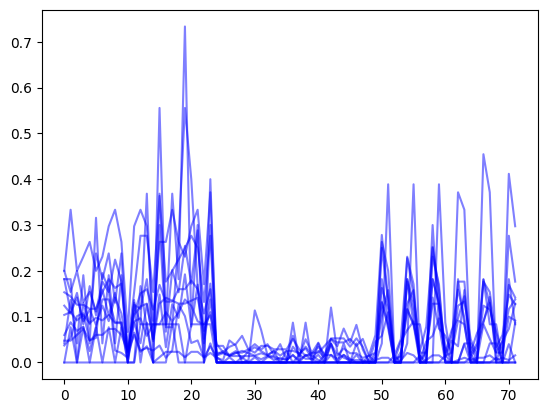

In [19]:
for pg in good_bad_counts:
    good_ypts, bad_ypts = list(zip(*[good_bad_counts[pg][f] for f in good_bad_counts[pg]]))
    xpts = range(len(xlabels))
    gb_ratio = [bad_ypts[i]/good_ypts[i] for i in range(len(good_ypts))]
    plt.plot(xpts, gb_ratio, c='b', alpha=0.5)

In [198]:
pg = protein_groups[0]
pg.normalize_intensities()

[167, 174, 169, 176, 167, 172, 175, 177, 168, 176, 178, 173, 170, 175, 171, 174, 170, 174, 173, 177, 171, 174, 170, 173, 175, 179, 176, 179, 174, 177, 177, 179, 177, 179, 176, 181, 179, 182, 179, 181, 179, 182, 179, 182, 179, 182, 179, 182, 181, 176, 173, 173, 181, 177, 171, 173, 181, 177, 175, 174, 179, 173, 170, 167, 179, 172, 169, 168, 178, 176, 170, 169]
{'08-17-24_B_eFASP-bio2_Tryp_EThcD-calib.mzML': 1.6041404012500087e-06, '08-17-24_B_eFASP-bio2_Tryp_HCD-calib.mzML': 1.8943089119756105e-06, '08-17-24_B_eFASP-bio3_Tryp_EThcD-calib.mzML': 2.4479393554067605e-06, '08-17-24_B_eFASP-bio3_Tryp_HCD-calib.mzML': 1.5356127611093176e-06, '08-17-24_L_eFASP-bio2_Tryp_EThcD-calib.mzML': 2.5329442618286357e-06, '08-17-24_L_eFASP-bio2_Tryp_HCD-calib.mzML': 3.999737263313576e-06, '08-17-24_L_eFASP-bio3_Tryp_EThcD-calib.mzML': 1.5384749947539755e-06, '08-17-24_L_eFASP-bio3_Tryp_HCD-calib.mzML': 1.562402877406731e-06, '08-17-24_U_eFASP-bio2_Tryp_EThcD-calib.mzML': 2.261722119573335e-06, '08-17-24_

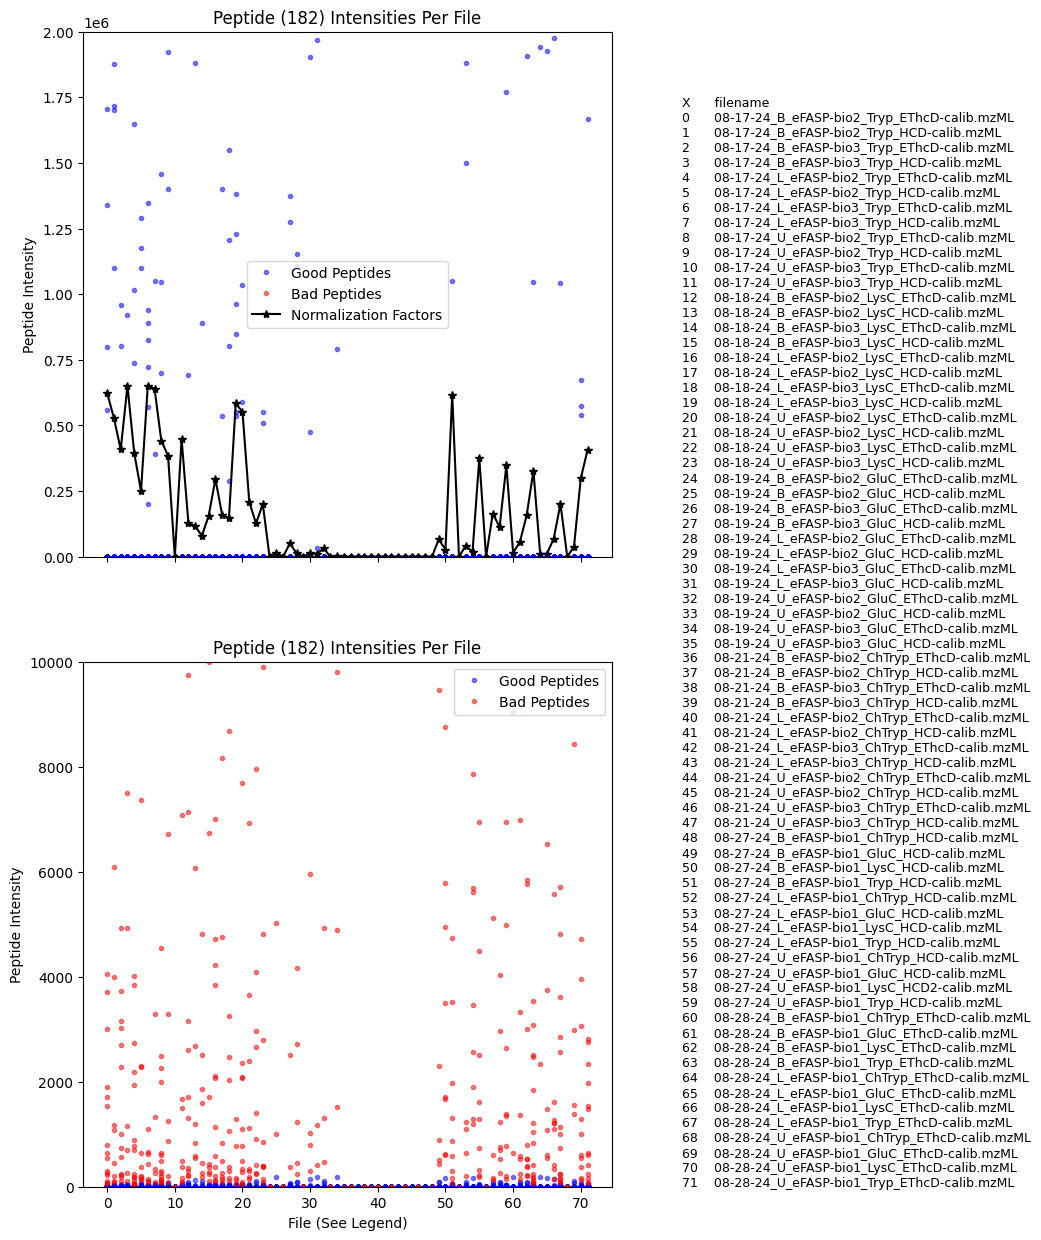

In [202]:
fig, ((ax1, legend_box), (ax2, _)) = plt.subplots(2, 2,
                                                  figsize=(10, 15),
                                                  width_ratios=(3, 1), sharex=True)
xlabels = sorted(p.spectrafiles)

ax1.set_title(f"Peptide ({len(pg.peptides)}) Intensities Per File")
ax1.set_ylabel("Peptide Intensity")    
x1pts_good, y1pts_good = zip(*[(xlabels.index(f), p.intensities_per_file[f]) for f in pg.spectrafiles for p in pg.good_bad_per_file[f]['good'] ])
x1pts_bad, y1pts_bad = zip(*[(xlabels.index(f), p.intensities_per_file[f]) for f in pg.spectrafiles for p in pg.good_bad_per_file[f]['bad']])
ax1.plot(x1pts_good, y1pts_good, 'o', ms=3, c='b', alpha=0.5, label='Good Peptides')
ax1.plot(x1pts_bad, y1pts_bad, 'o', ms=3, c='r', alpha=0.5, label='Bad Peptides')
ax1.plot(range(len(xlabels)), [1/pg.norms_per_file[f] if pg.norms_per_file[f] else 0 for f in xlabels], marker='*', c='k', label="Normalization Factors") 
ax1.set_ylim(-5, 2*1e6 + 5)
ax1.legend()


ax2.set_title(f"Peptide ({len(pg.peptides)}) Intensities Per File")
ax2.set_xlabel("File (See Legend)")
ax2.set_ylabel("Peptide Intensity")
x2pts_good, y2pts_good = zip(*[(xlabels.index(f), p.normalized_intensities_per_file[f]) for f in pg.spectrafiles for p in pg.good_bad_per_file[f]['good'] ])
x2pts_bad, y2pts_bad = zip(*[(xlabels.index(f), p.normalized_intensities_per_file[f]) for f in pg.spectrafiles for p in pg.good_bad_per_file[f]['bad']])
ax2.plot(x2pts_good, y2pts_good, 'o', ms=3, c='b', alpha=0.5, label='Good Peptides')
ax2.plot(x2pts_bad, y2pts_bad, 'o', ms=3, c='r', alpha=0.5, label='Bad Peptides')
ax2.set_ylim(-1, 1e4)
ax2.legend()


gs = legend_box.get_gridspec()
legend_box.remove()
_.remove()
legend_box = fig.add_subplot(gs[1:, -1])
col_space = 8
legend_lines = [f"X{' '*(col_space-2)}filename"] + list(map(''.join, [[str(i), ' '*(col_space-2*len(str(i))), l] for i,l in enumerate(xlabels)]))
legend_lines = toolz.interpose('\n', legend_lines)
legend_box.text(0,0, ''.join(legend_lines), fontsize=9)
for i in legend_box.get_children()[1:]:
    i.set_visible(False)
plt.show()

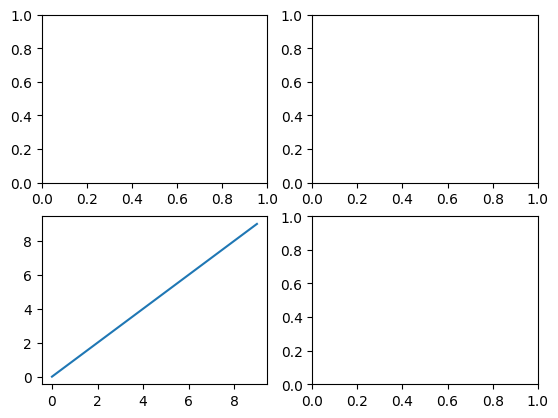

In [99]:
fig, ((a, b), (c, d)) = plt.subplots(2, 2)
c.plot(range(10), range(10))